In [9]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from src.data.datasets import DataModule

import scipy
import numpy as np
from sklearn import datasets
from evidently.report import Report
from evidently.metrics import DataDriftTable
from evidently.metrics import DatasetDriftMetric
from sklearn.metrics import mean_absolute_error

In [14]:
def load_tensors(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)
        
    for i in range(len(outputs)):
        if i == 0:
            x_real = outputs[i]['x_real']
            x_fake = outputs[i]['x_fake']
            d_pred = outputs[i]['d_pred']
            imputation = outputs[i]['imputation']
            input_mask_int = outputs[i]['input_mask_int']
            input_mask_bool = outputs[i]['input_mask_bool']
            known_values = outputs[i]['known_values']
        else:
            x_real = torch.cat([x_real, outputs[i]['x_real']], dim=0)
            x_fake = torch.cat([x_fake, outputs[i]['x_fake']], dim=0)
            d_pred = torch.cat([d_pred, outputs[i]['d_pred']], dim=0)
            imputation = torch.cat([imputation, outputs[i]['imputation']], dim=0)
            input_mask_int = torch.cat([input_mask_int, outputs[i]['input_mask_int']], dim=0)
            input_mask_bool = torch.cat([input_mask_bool, outputs[i]['input_mask_bool']], dim=0)
            known_values = torch.cat([known_values, outputs[i]['known_values']], dim=0)
            
    return x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values

def load_tensors_denorm(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)

    for i in range(len(outputs)):
        if i == 0:
            x_real = outputs[i]['real']
            x_fake = outputs[i]['fake']
        else:
            x_real = np.concatenate([x_real, outputs[i]['real']])
            x_fake = np.concatenate([x_fake, outputs[i]['fake']])

    return x_real, x_fake
        
    
def prepare_data(x_real, x_fake, imputation, input_mask_bool):
    x1 = x_real[~input_mask_bool].flatten().cpu().detach().numpy()
    x2 = x_fake[~input_mask_bool].flatten().cpu().detach().numpy()
    
    df1 = pd.DataFrame({'x': x1, 'type': ['real' for _ in range(len(x1))]})
    df2 = pd.DataFrame({'x': x2, 'type': ['G' for _ in range(len(x2))]})
    
    diff = imputation[~input_mask_bool].flatten().cpu().detach().numpy() - x_real[~input_mask_bool].flatten().cpu().detach().numpy()
    return pd.concat([df1, df2]), diff

def plot_figures(df, diff, d_pred, input_mask_bool):
    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='count', common_norm=False)
    plt.title('Histograma de valores reales y generados por G')
    plt.xlabel('Valor generado')
    plt.show()
    
    plt.figure()
    plt.title(f"Histograma de errores cometidos por G (y'-y) (MAE: {np.mean(np.abs(diff)):.2f})")
    plt.xlabel('Error cometido')
    sns.histplot(data=diff, stat='count')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred.flatten().cpu().detach().numpy(), stat='count')
    plt.title('Histograma de predicciones de D (todos)')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred[input_mask_bool].flatten().cpu().detach().numpy(), stat='count')
    plt.title('Histograma de predicciones de D (reales)')
    plt.show()
    
    plt.figure()
    sns.histplot(data=d_pred[~input_mask_bool].flatten().cpu().detach().numpy(), stat='count')
    plt.title('Histograma de predicciones de D (falsos)')
    plt.show()

def plot_figures_denorm(path):
    x_real, x_fake = load_tensors_denorm(path)
    data = pd.DataFrame({'x': x_real, 'type': ['real' for _ in range(len(x_real))]})
    data = pd.concat([data, pd.DataFrame({'x': x_fake, 'type': ['G' for _ in range(len(x_fake))]}).reset_index(drop=True)], axis=0)

    plt.figure()
    sns.histplot(data=data, x='x', hue='type', stat='count', common_norm=False)
    plt.title('Histograma de valores reales y generados por G')
    plt.xlabel('Valor generado')
    
    plt.figure()
    sns.histplot(data=x_fake - x_real, stat='count')
    plt.title(f'Histograma errores de valores desnormalizados (MAE: {np.mean(np.abs(x_fake - x_real)):.2f})')
    plt.show()


def get_report(train, test):

    data_drift_dataset_report = Report(metrics=[

    DatasetDriftMetric(),

    DataDriftTable(),    

    ])

    df_train_x = pd.DataFrame(train)
    df_test_x = pd.DataFrame(test)

    df_train_x.columns = ['x']
    df_test_x.columns = ['x']

    data_drift_dataset_report.run(
    reference_data=df_train_x,
    current_data=df_test_x,
    )

    print(data_drift_dataset_report.json())

def get_values(dataloader):
    for i, batch in enumerate(dataloader):
        x, x_real, input_mask_bool, input_mask_int, known_values, time_gap_matrix = batch
        if i == 0:
            res = x_real
        else: 
            torch.cat([res, x_real], dim=0)
            
    return x_real.flatten().cpu().detach().numpy()

def plot_results(train, test):
    df1 = pd.DataFrame({'x': train, 'type': ['train' for _ in range(len(train))]})
    df2 = pd.DataFrame({'x': test, 'type': ['test' for _ in range(len(test))]})

    df = pd.concat([df1, df2], axis=0)

    plt.figure()
    sns.histplot(data=df, x='x', hue='type', stat='density', common_norm=False)
    plt.title('Histograma de los valores de train y de test')
    plt.xlabel('Valores reales')
    plt.show()

    get_report(train, test)
    
def plot_dist(data):
    plt.figure()
    sns.histplot(data=data, stat='count', common_norm=False)
    plt.title('Histograma de los valores reales')
    plt.xlabel('Valores reales')
    plt.show()
        

# Análisis de resultados con H=0.9

In [ ]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.9.pkl')
df_9, diff_9 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures(df_9, diff_9, d_pred, input_mask_bool)

# Análisis de resultados con H=0.1

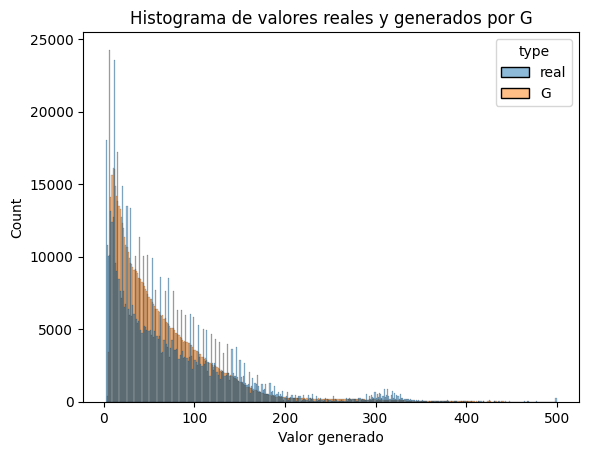

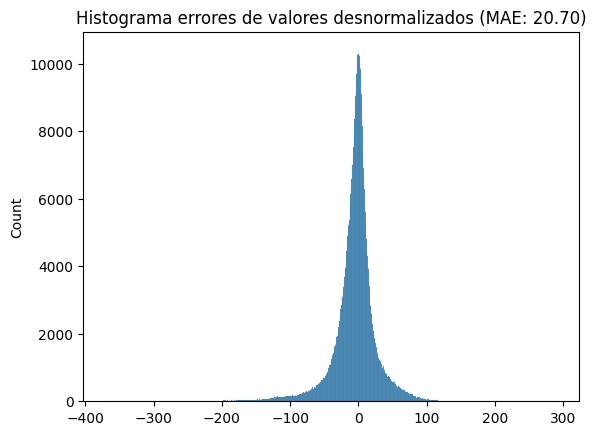

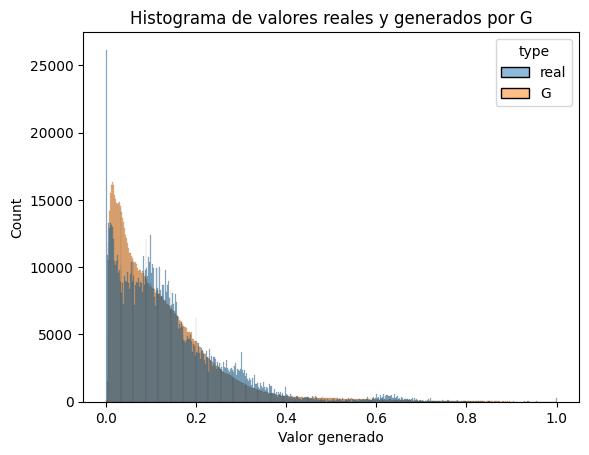

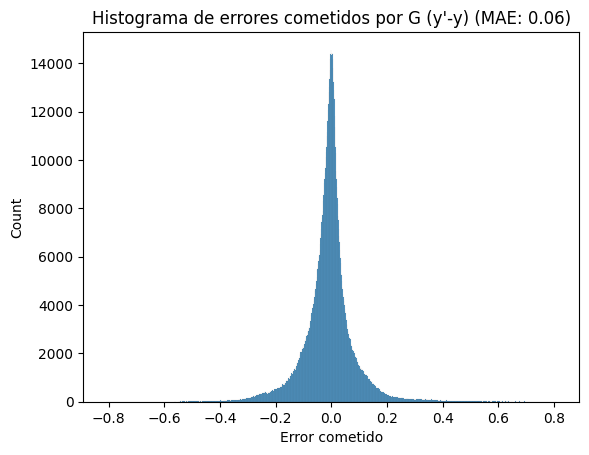

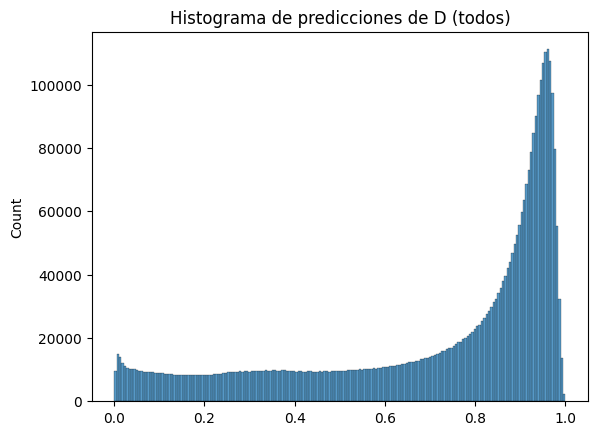

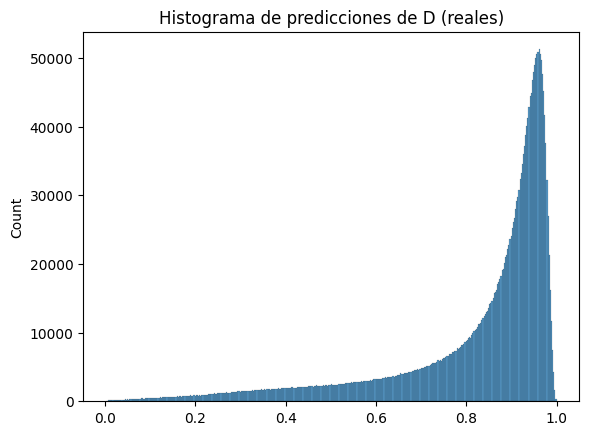

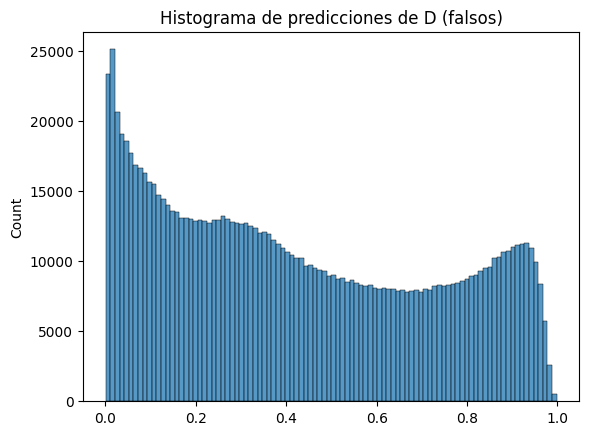

In [12]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.2_air-36.pkl')
df_1, diff_1 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures_denorm('./outputs_test_denorm_h_0.2_air-36.pkl')
plot_figures(df_1, diff_1, d_pred, input_mask_bool)

In [3]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.9.pkl')
df_1, diff_1 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures_denorm('./outputs_test_denorm_h_0.9.pkl')
plot_figures(df_1, diff_1, d_pred, input_mask_bool)

EOFError: Ran out of input

In [21]:
x_real, x_fake, d_pred, imputation, input_mask_int, input_mask_bool, known_values = load_tensors('outputs_test_h_0.1_ratio.pkl')
df_1, diff_1 = prepare_data(x_real, x_fake, imputation, input_mask_bool)
plot_figures(df_1, diff_1, d_pred, input_mask_bool)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs_test_h_0.1_ratio.pkl'

# Análisis de las distribuciones de los datos

(8760, 437)
air
out
Missing percentaje: 35.46


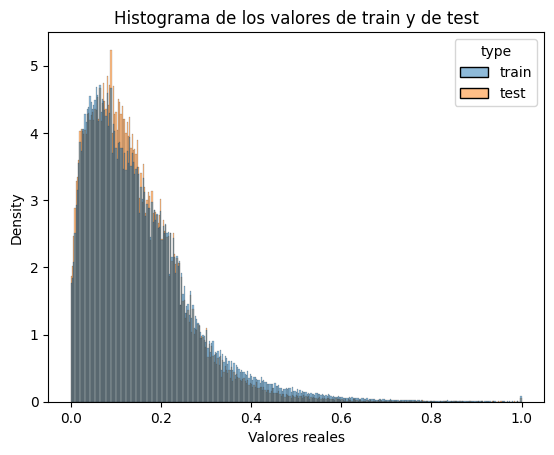

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.09968948858286907, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [4.047005740381542, 3.527364291799156, 1.6906937235281048, 0.4910374053169278, 0.15412849109424664, 0.056922183225032626, 0.01935544923732265, 0.007961482633670643, 0.00233

In [4]:
dm = DataModule(dataset='air_out')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

(8760, 437)
air
in
Missing percentaje: 36.31


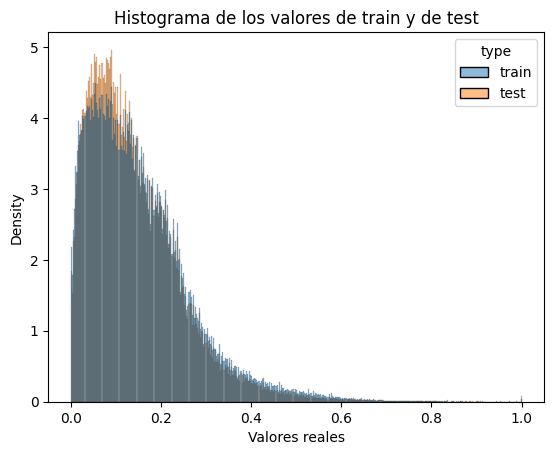

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.08384733827564525, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [4.131038845541385, 3.424619327137609, 1.685012061485094, 0.4936935022388918, 0.17039878251858295, 0.05839154922536773, 0.021742530503220468, 0.008410976092885582, 0.003226

In [5]:
dm = DataModule(dataset='air_in')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

(8759, 36)
air
Missing percentaje: 24.61


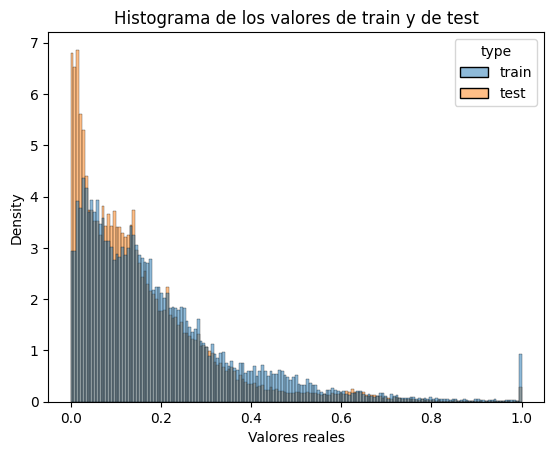

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.23355327596376507, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.09999999403953552, 0.19999998807907104, 0.29999998211860657, 0.3999999761581421, 0.4999999701976776, 0.5999999642372131, 0.6999999284744263, 0.7999999523162842, 0.8999999761581421, 0.9999999403953552], "y": [4.438519885367689, 2.798377040693977, 1.468529628977395, 0.6413277498663243, 0.24388228966879236, 0.15955688781720995, 0.15569890929778937, 0.05098102840954954, 0.018325612914

In [7]:
dm = DataModule(dataset='air-36_in')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

(8759, 36)
air
Missing percentaje: 24.61


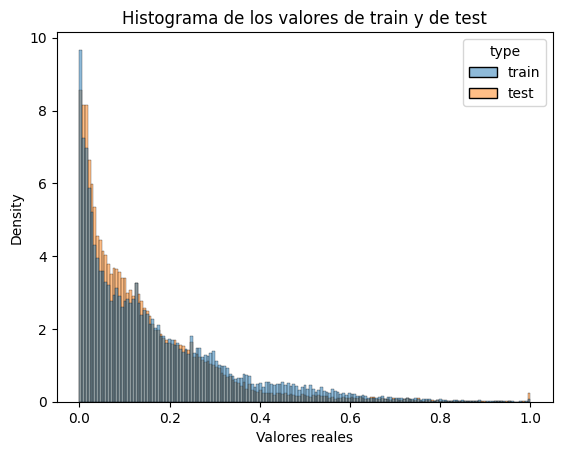

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.17921276394145172, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.09999999403953552, 0.19999998807907104, 0.29999998211860657, 0.3999999761581421, 0.4999999701976776, 0.5999999642372131, 0.6999999284744263, 0.7999999523162842, 0.8999999761581421, 0.9999999403953552], "y": [5.074473957665039, 2.4607998600789815, 1.357404732583112, 0.5678874897570213, 0.21901180758674885, 0.13902668377164493, 0.09390159883756058, 0.05098102840954954, 0.01563877493

In [12]:
dm = DataModule(dataset='air-36_in')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis datadrif en la

(34272, 207)
other
Missing percentaje: 31.08


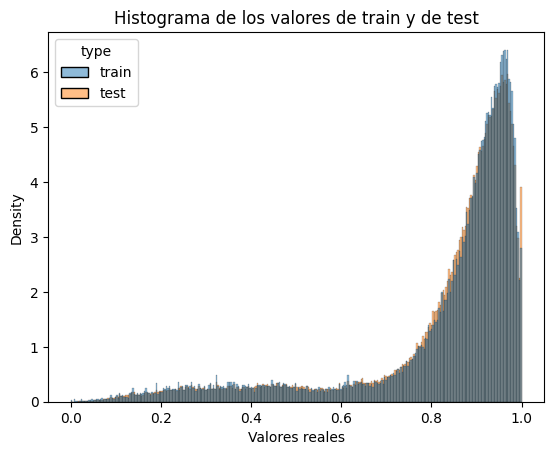

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.024135447196411423, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.10000000894069672, 0.20000001788139343, 0.30000004172325134, 0.40000003576278687, 0.5000000596046448, 0.6000000834465027, 0.7000001072883606, 0.8000000715255737, 0.9000000953674316, 1.0000001192092896], "y": [0.03029699083341301, 0.14509353418302998, 0.23984422457042015, 0.263168832194211, 0.2932167237567085, 0.2446792915651345, 0.3539559559177761, 0.830117168563191, 2.6593906

In [9]:
dm = DataModule(dataset='la_point')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis Bay

Missing percentaje: 25.02


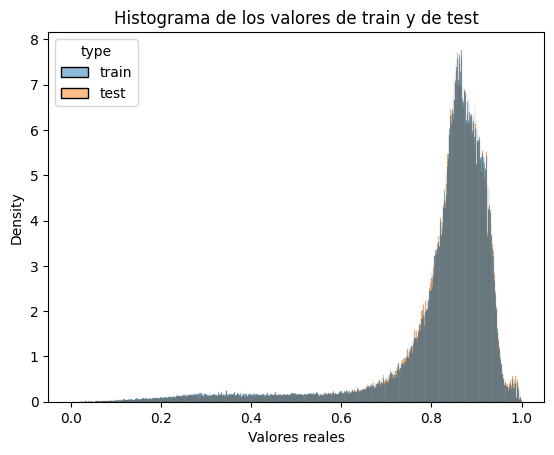

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.028903666006720636, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0], "y": [0.007466891971011336, 0.04902789445116878, 0.11555366676083574, 0.13608059419162158, 0.1383770158556897, 0.1602986374651177, 0.30567776499654326, 1.2709351717670707, 5.523219783090512, 2.2933637811991785

In [14]:
dm = DataModule(dataset='bay_point')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Análisis electric

0.25
(2208, 6)
Missing percentaje: 25.2


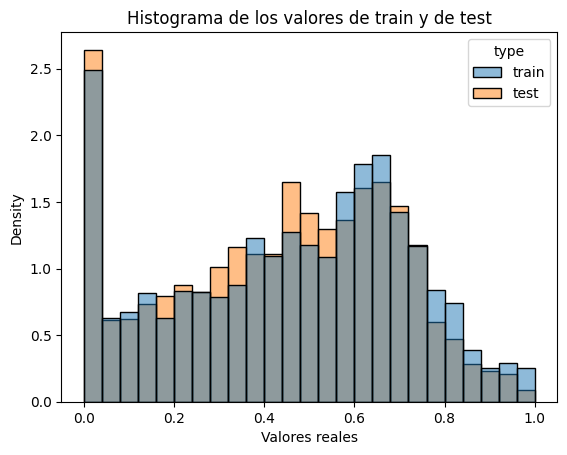

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 0, "share_of_drifted_columns": 0.0, "dataset_drift": false, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.08563231733731004, "drift_detected": false, "current": {"small_distribution": {"x": [0.0, 0.09999999403953552, 0.19999998807907104, 0.29999998211860657, 0.3999999761581421, 0.4999999701976776, 0.5999999642372131, 0.6999999284744263, 0.7999999523162842, 0.8999999761581421, 0.9999999403953552], "y": [1.422325187657846, 0.7407407848923322, 0.8744856488312255, 1.1188272271811266, 1.4403293039573124, 1.2962963735615813, 1.6126548977179884, 0.9825100538171926, 0.34207810774

In [14]:
dm = DataModule(dataset='electric_0.25')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

# Comparación de distribución de valores de G en test y distribución de train

(8759, 36)
Missing percentaje: 24.61


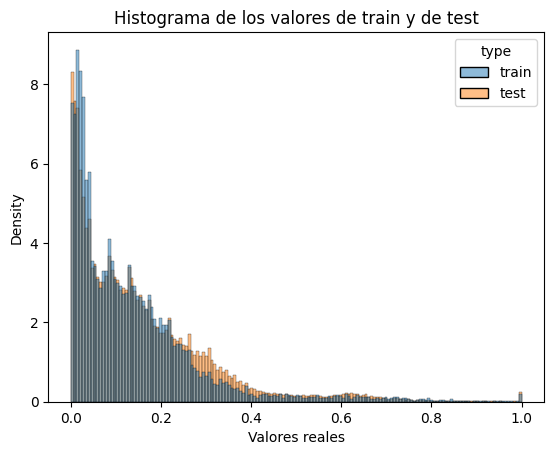

{"version": "0.4.0", "metrics": [{"metric": "DatasetDriftMetric", "result": {"drift_share": 0.5, "number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true}}, {"metric": "DataDriftTable", "result": {"number_of_columns": 1, "number_of_drifted_columns": 1, "share_of_drifted_columns": 1.0, "dataset_drift": true, "drift_by_columns": {"x": {"column_name": "x", "column_type": "num", "stattest_name": "Wasserstein distance (normed)", "stattest_threshold": 0.1, "drift_score": 0.12610773569671768, "drift_detected": true, "current": {"small_distribution": {"x": [0.0, 0.09999999403953552, 0.19999998807907104, 0.29999998211860657, 0.3999999761581421, 0.4999999701976776, 0.5999999642372131, 0.6999999284744263, 0.7999999523162842, 0.8999999761581421, 0.9999999403953552], "y": [4.545580076934159, 2.603546782167608, 1.5219219381562972, 0.7140790769539641, 0.22142307316257023, 0.14502040106011524, 0.15693898910635584, 0.05380565295656513, 0.01708553384

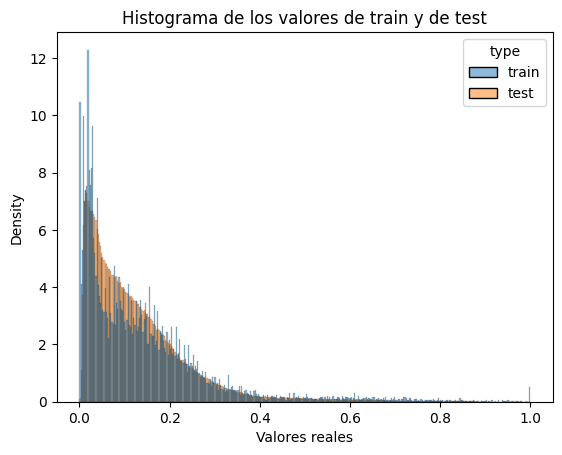

In [20]:
dm = DataModule(dataset='air-36_in')
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

plot_results(train_x, test_x)

df1 = pd.DataFrame({'x': train_x, 'type': ['train' for _ in range(len(train_x))]})
df2 = pd.DataFrame({'x': df_1[df_1.type == 'G']['x'], 'type': ['test' for _ in range(len(df_1[df_1.type == 'G']))]})

df = pd.concat([df1, df2], axis=0)

plt.figure()
sns.histplot(data=df, x='x', hue='type', stat='density', common_norm=False)
plt.title('Histograma de los valores de train y de test')
plt.xlabel('Valores reales')
plt.show()

<Axes: xlabel='x', ylabel='Density'>

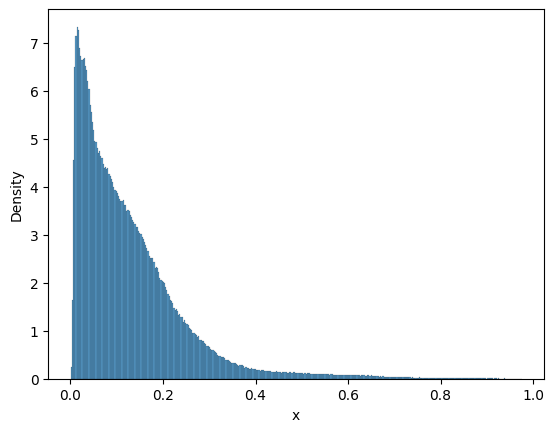

In [17]:
sns.histplot(data=df_1[df_1.type == 'G']['x'], stat='density')

In [4]:
dm1 = DataModule(dataset='air-36_in')
dm1.setup()

train_loader = dm1.train_dataloader()
test_loader = dm1.test_dataloader()

train_x1 = get_values(train_loader)
test_x1 = get_values(test_loader)

(8759, 36)
air
in
Missing percentaje: 24.61


In [7]:
dm2 = DataModule(dataset='air-36_in')
dm2.setup()

train_loader = dm2.train_dataloader()
test_loader = dm2.test_dataloader()

train_x2 = get_values(train_loader)
test_x2 = get_values(test_loader)

(8759, 36)
air
in
Missing percentaje: 24.61


In [12]:
print(train_x1.shape, train_x2.shape)
(np.sort(train_x1) == np.sort(train_x2)).all()

(25920,) (25920,)


False

In [15]:
print(test_x1.shape, test_x2.shape)
(np.sort(test_x1) == np.sort(test_x2)).all()

(145152,) (145152,)


False

In [8]:
scipy.stats.shapiro(train_x1)

/home/javier/anaconda3/envs/tsl/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8467636108398438, pvalue=0.0)

# Comprobación de normalidad

(8759, 36)
air
in
Missing percentaje: 24.61
(4000,)


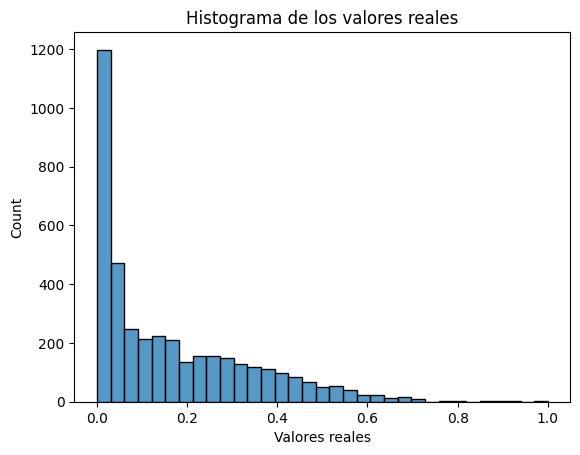

ShapiroResult(statistic=0.8529778122901917, pvalue=0.0)

In [27]:
dm1 = DataModule(dataset='air-36_in')
dm1.setup()

train_loader = dm1.train_dataloader()
test_loader = dm1.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

data = np.random.choice(train_x, 4000)

plot_dist(data)
scipy.stats.shapiro(data)

(8760, 437)
air
in
Missing percentaje: 36.31


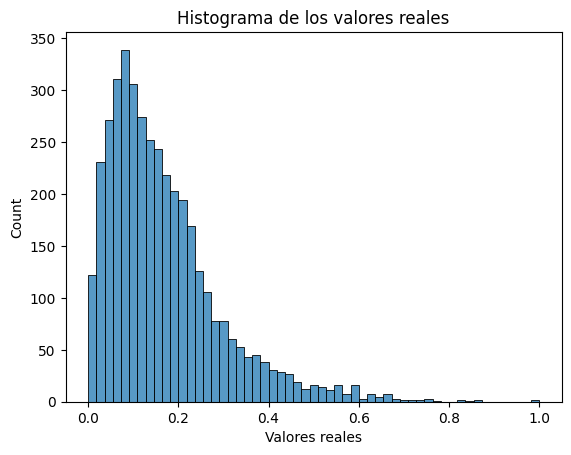

ShapiroResult(statistic=0.8725433349609375, pvalue=0.0)

In [28]:
dm1 = DataModule(dataset='air_in')
dm1.setup()

train_loader = dm1.train_dataloader()
test_loader = dm1.test_dataloader()

train_x = get_values(train_loader)
test_x = get_values(test_loader)

data = np.random.choice(train_x, 4000)

plot_dist(data)
scipy.stats.shapiro(data)

In [71]:
scipy.stats.kstest(data, 'lognorm', args=(100,))  


KstestResult(statistic=0.5000151978921414, pvalue=0.0, statistic_location=0.9961977, statistic_sign=1)

(34272, 207)
other
Missing percentaje: 31.15


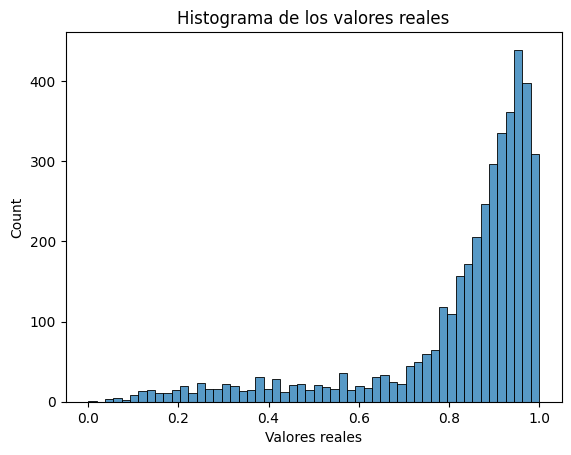

ShapiroResult(statistic=0.7349274754524231, pvalue=0.0)

In [29]:
dm1 = DataModule(dataset='la_point')
dm1.setup()

train_loader = dm1.train_dataloader()
val_loader = dm1.val_dataloader()
test_loader = dm1.test_dataloader()

train_x = get_values(train_loader)
val_x = get_values(val_loader)
test_x = get_values(test_loader)

data = np.concatenate((train_x, val_x, test_x), axis=0)

data = np.random.choice(data, 4000)

plot_dist(data)
scipy.stats.shapiro(data)

(52128, 325)
other
Missing percentaje: 25.03


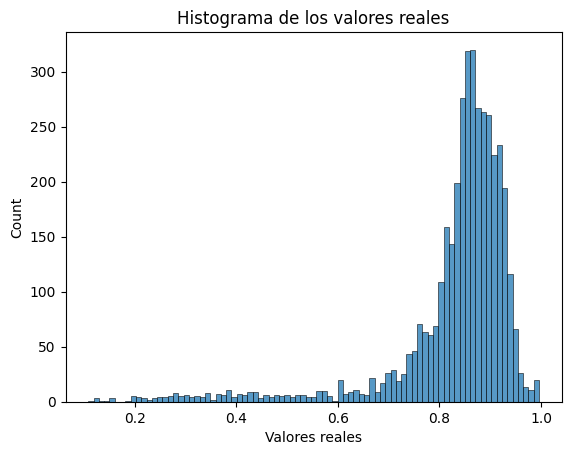

ShapiroResult(statistic=0.6955979466438293, pvalue=0.0)

In [30]:
dm1 = DataModule(dataset='bay_point')
dm1.setup()

train_loader = dm1.train_dataloader()
val_loader = dm1.val_dataloader()
test_loader = dm1.test_dataloader()

train_x = get_values(train_loader)
val_x = get_values(val_loader)
test_x = get_values(test_loader)

data = np.concatenate((train_x, val_x, test_x), axis=0)
data = np.random.choice(data, 4000)

plot_dist(data)
scipy.stats.shapiro(data)